In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# Set paths
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
results_path = os.path.join(base_path, 'results', 'forecasts_ili_sir_1980_2024_weekly')
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')

# Load data
preds = np.load(os.path.join(results_path, 'predictions.npy'))
trues = np.load(os.path.join(results_path, 'true_values.npy'))
df = pd.read_csv(os.path.join(data_path, 'ili_seasonal_sir_1980_2024_weekly.csv'))
df['date'] = pd.to_datetime(df['date'])

# Parameters
pred_len = 14
seq_len = 28

# CORRECTED: Calculate test border the same way Dataset_Custom does
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_vali = len(df) - num_train - num_test

# This is where test data ACTUALLY starts
test_border1 = len(df) - num_test - seq_len

print(f"Dataset length: {len(df)}")
print(f"num_train: {num_train}, num_vali: {num_vali}, num_test: {num_test}")
print(f"Test border1 (actual test start): {test_border1}")
print(f"Wrong calculation (train+val): {num_train + num_vali}")
print(f"Difference: {(num_train + num_vali) - test_border1} rows!\n")





Dataset length: 2349
num_train: 1644, num_vali: 236, num_test: 469
Test border1 (actual test start): 1852
Wrong calculation (train+val): 1880
Difference: 28 rows!



In [ ]:
df


,date,S,I,R
0,1980-01-01,99899000,1000,100000
1,1980-01-08,99896251,2220,101530
2,1980-01-15,99890173,4906,104920
3,1980-01-22,99876891,10742,112367
4,1980-01-29,99848177,23232,128591
...,...,...,...,...
2344,2024-12-03,47992800,0,52007200
2345,2024-12-10,47992800,0,52007200
2346,2024-12-17,47992800,0,52007200
2347,2024-12-24,47992800,0,52007200


Sample 0:
  History: original rows 1852-1879
  Forecast: original rows 1880-1893
  History dates: 2015-06-30 00:00:00 to 2016-01-05 00:00:00
  Forecast dates: 2016-01-12 00:00:00 to 2016-04-12 00:00:00
  CSV truth: [0 0 0]
  Model truth: [-0.00025186 -0.00025186 -0.00025186]
  Match: False

Sample 1:
  History: original rows 1853-1880
  Forecast: original rows 1881-1894
  History dates: 2015-07-07 00:00:00 to 2016-01-12 00:00:00
  Forecast dates: 2016-01-19 00:00:00 to 2016-04-19 00:00:00
  CSV truth: [0 0 0]
  Model truth: [-0.00025186 -0.00025186 -0.00025186]
  Match: False

Sample 2:
  History: original rows 1854-1881
  Forecast: original rows 1882-1895
  History dates: 2015-07-14 00:00:00 to 2016-01-19 00:00:00
  Forecast dates: 2016-01-26 00:00:00 to 2016-04-26 00:00:00
  CSV truth: [0 0 0]
  Model truth: [-0.00025186 -0.00025186 -0.00025186]
  Match: False

Sample 3:
  History: original rows 1855-1882
  Forecast: original rows 1883-1896
  History dates: 2015-07-21 00:00:00 to 201

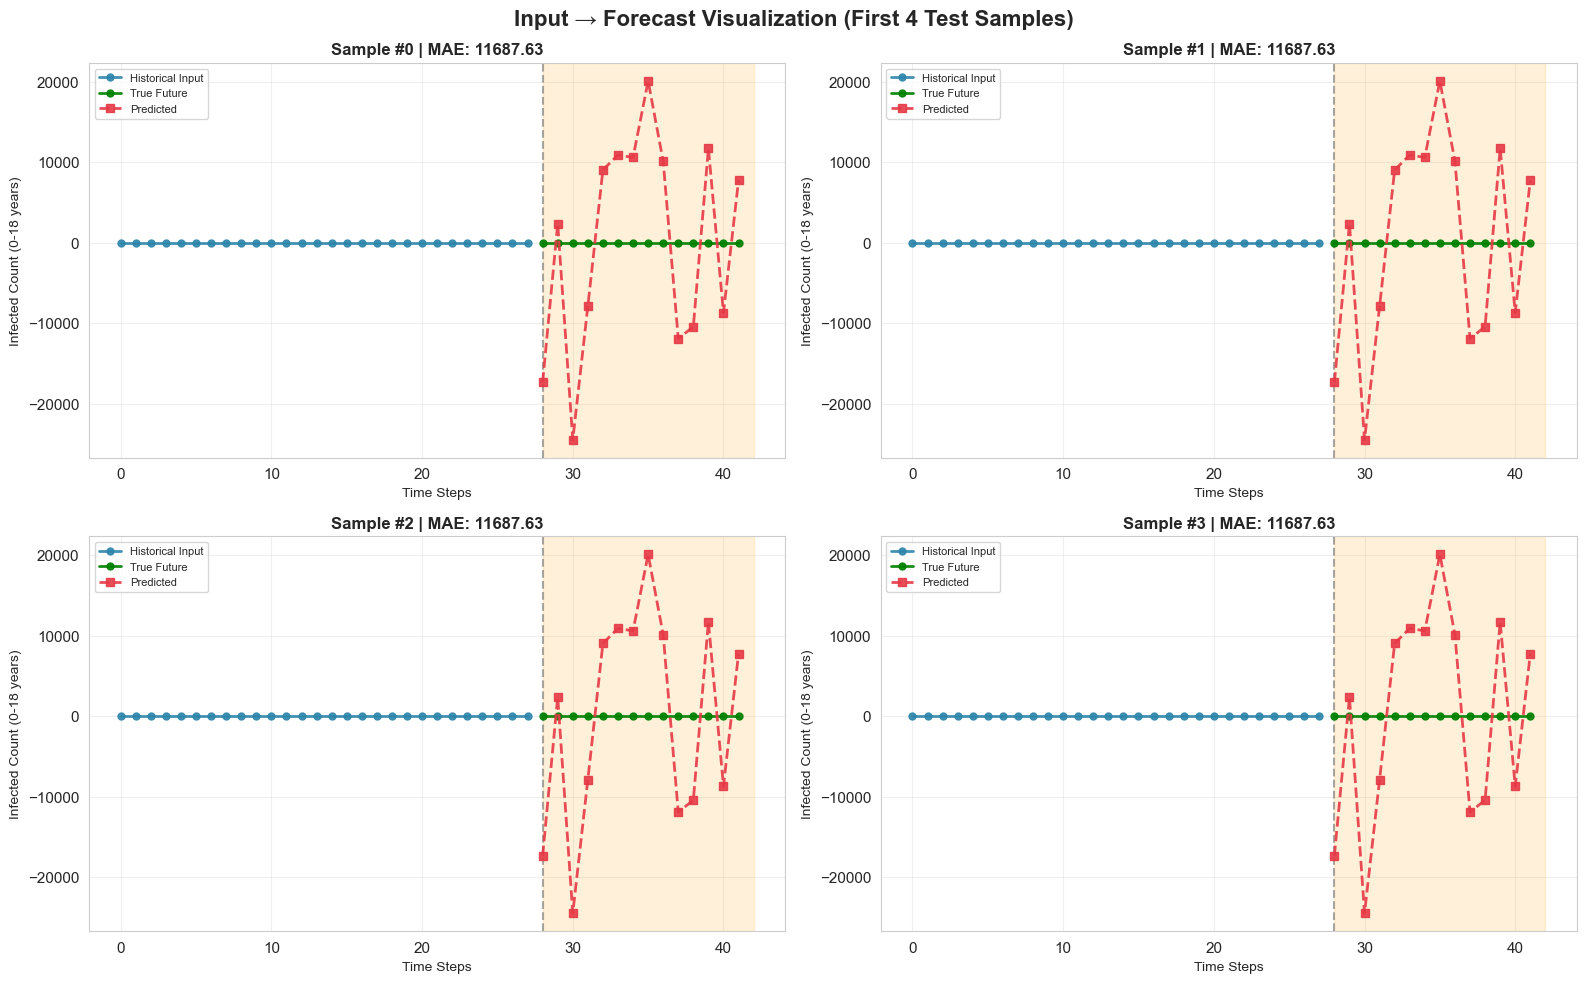

In [3]:
# Create a grid of 4 samples
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Input → Forecast Visualization (First 4 Test Samples)', 
             fontsize=16, fontweight='bold')

for idx in range(min(4, len(preds))):
    ax = axes[idx // 2, idx % 2]
    
    # CORRECTED: Get data for this sample using test_border1
    history_start = test_border1 + idx
    history_end = history_start + seq_len
    forecast_start_idx = history_end
    forecast_end_idx = forecast_start_idx + pred_len
    
    print(f"Sample {idx}:")
    print(f"  History: original rows {history_start}-{history_end-1}")
    print(f"  Forecast: original rows {forecast_start_idx}-{forecast_end_idx-1}")
    print(f"  History dates: {df.iloc[history_start]['date']} to {df.iloc[history_end-1]['date']}")
    print(f"  Forecast dates: {df.iloc[forecast_start_idx]['date']} to {df.iloc[forecast_end_idx-1]['date']}")
    
    # Extract data from CSV
    historical_data = df.iloc[history_start:history_end]['I'].values
    true_future_csv = df.iloc[forecast_start_idx:forecast_end_idx]['I'].values
    
    # Get model predictions
    pred_future = preds[idx, :, 0]
    true_future_model = trues[idx, :, 0]
    
    # Verify they match
    print(f"  CSV truth: {true_future_csv[:3]}")
    print(f"  Model truth: {true_future_model[:3]}")
    print(f"  Match: {np.allclose(true_future_csv, true_future_model, rtol=0.01)}\n")
    
    mae = np.mean(np.abs(pred_future - true_future_csv))
    
    history_steps = np.arange(len(historical_data))
    forecast_steps = np.arange(len(historical_data), len(historical_data) + pred_len)
    
    # Plot
    ax.plot(history_steps, historical_data, 'o-', color='#2E86AB', linewidth=2, 
            markersize=5, label='Historical Input', alpha=0.9, zorder=3)
    ax.plot(forecast_steps, true_future_csv, 'o-', color='green', linewidth=2, 
            markersize=5, label='True Future', alpha=0.9, zorder=3)
    ax.plot(forecast_steps, pred_future, 's--', color='#E63946', linewidth=2, 
            markersize=6, label='Predicted', alpha=0.9, zorder=4)
    
    ax.axvline(x=len(historical_data), color='gray', linestyle='--', 
               linewidth=1.5, alpha=0.7, zorder=2)
    ax.axvspan(len(historical_data), len(historical_data) + pred_len, 
               alpha=0.15, color='orange', zorder=1)
    
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Infected Count (0-18 years)', fontsize=10)
    ax.set_title(f'Sample #{idx} | MAE: {mae:.2f}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_path, 'forecast_grid_CORRECTED.png'), 
            dpi=300, bbox_inches='tight')
plt.show()


Full dataset: 2349 days (1980-01-01 to 2024-12-31)
Training data: 0 to 1643 (1980-01-01 to 2011-06-28)
Forecast window: 1880 to 1893 (2016-01-12 to 2016-04-12)

Plot saved to: /Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/results/forecasts_ili_sir_1980_2024_weekly/full_timeline_sample_0.png


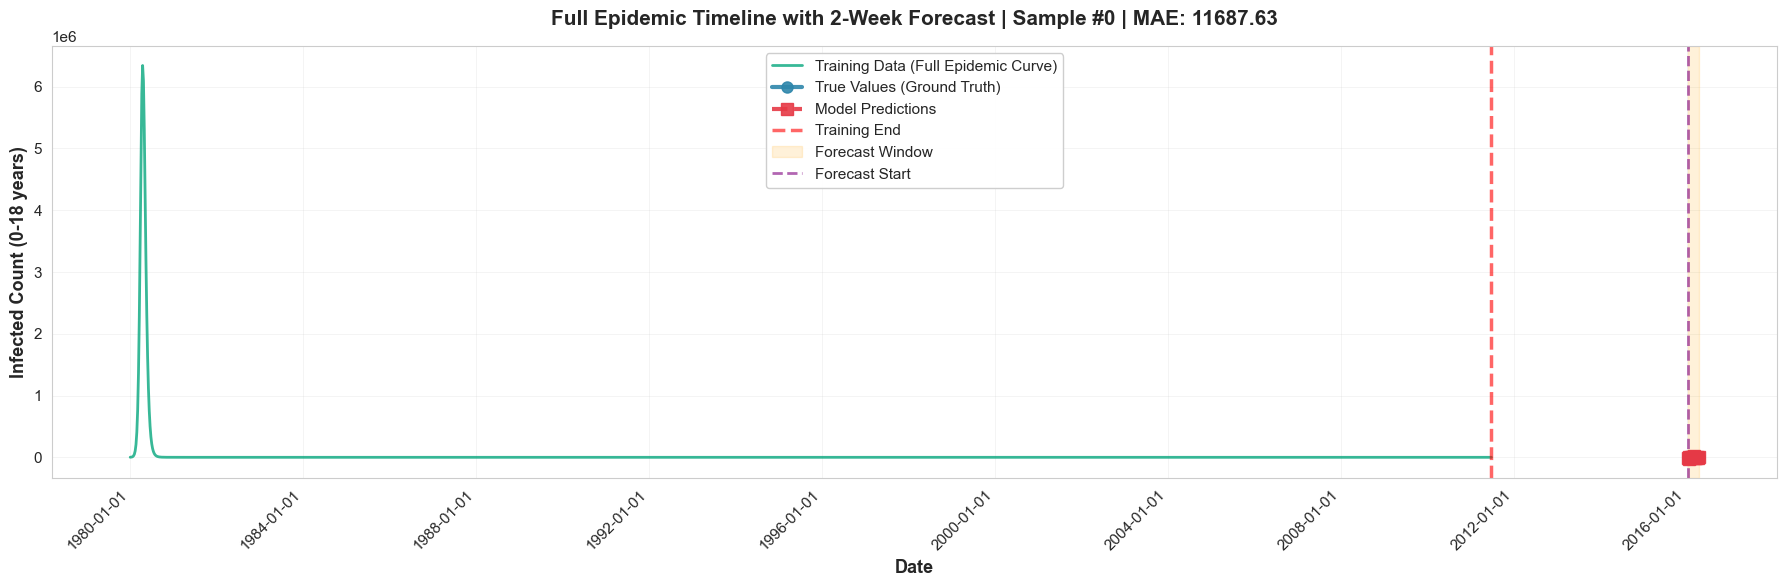


VISUALIZATION SUMMARY
Training data points: 1644
Training range: [0.00, 6343158.00]
Forecast period: 14 days
True values range: [0.00, 0.00]
Predicted range: [-24519.17, 20135.58]
MAE: 11687.63
MAPE: inf%


/var/folders/lw/dgg3fc653n92s3t3jp2233n40000gn/T/ipykernel_15562/2756167798.py:119: RuntimeWarning: divide by zero encountered in divide
  print(f"MAPE: {np.mean(np.abs((forecast_true - forecast_pred) / forecast_true)) * 100:.2f}%")


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# Set paths
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
results_path = os.path.join(base_path, 'results', 'forecasts_ili_sir_1980_2024_weekly')
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')

# Load data
preds = np.load(os.path.join(results_path, 'predictions.npy'))
trues = np.load(os.path.join(results_path, 'true_values.npy'))
df = pd.read_csv(os.path.join(data_path, 'ili_seasonal_sir_1980_2024_weekly.csv'))
df['date'] = pd.to_datetime(df['date'])

# Parameters
pred_len = 14
seq_len = 28

# Calculate test border (corrected)
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_vali = len(df) - num_train - num_test
test_border1 = len(df) - num_test - seq_len

# Select which sample to visualize
sample_idx = 0

# Get forecast window indices
forecast_start_idx = test_border1 + sample_idx + seq_len
forecast_end_idx = forecast_start_idx + pred_len

print(f"Full dataset: {len(df)} days ({df.iloc[0]['date'].date()} to {df.iloc[-1]['date'].date()})")
print(f"Training data: 0 to {num_train-1} ({df.iloc[0]['date'].date()} to {df.iloc[num_train-1]['date'].date()})")
print(f"Forecast window: {forecast_start_idx} to {forecast_end_idx-1} ({df.iloc[forecast_start_idx]['date'].date()} to {df.iloc[forecast_end_idx-1]['date'].date()})")

# Extract data
training_data = df.iloc[:num_train]['I'].values
training_dates = df.iloc[:num_train]['date'].values

forecast_true = df.iloc[forecast_start_idx:forecast_end_idx]['I'].values
forecast_pred = preds[sample_idx, :, 0]
forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date'].values

# Calculate MAE
mae = np.mean(np.abs(forecast_pred - forecast_true))

# Create figure
fig, ax = plt.subplots(figsize=(18, 6))

# Plot training data (full epidemic curve)
ax.plot(training_dates, training_data, color='#06A77D', linewidth=2, 
        label='Training Data (Full Epidemic Curve)', alpha=0.8)

# Plot true values in forecast window
ax.plot(forecast_dates, forecast_true, 'o-', color='#2E86AB', linewidth=3, 
        markersize=8, label='True Values (Ground Truth)', alpha=0.9, zorder=3)

# Plot predictions
ax.plot(forecast_dates, forecast_pred, 's--', color='#E63946', linewidth=3, 
        markersize=9, label='Model Predictions', alpha=0.9, zorder=4)

# Add vertical line at training end
train_end_date = df.iloc[num_train-1]['date']
ax.axvline(x=train_end_date, color='red', linestyle='--', 
           linewidth=2.5, alpha=0.6, label='Training End', zorder=2)

# Shade forecast window
ax.axvspan(forecast_dates[0], forecast_dates[-1], 
           alpha=0.15, color='orange', label='Forecast Window', zorder=1)

# Add vertical line at forecast start
ax.axvline(x=forecast_dates[0], color='purple', linestyle='--', 
           linewidth=2, alpha=0.6, label='Forecast Start', zorder=2)

# Labels and title
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Infected Count (0-18 years)', fontsize=13, fontweight='bold')
ax.set_title(f'Full Epidemic Timeline with 2-Week Forecast | Sample #{sample_idx} | MAE: {mae:.2f}', 
             fontsize=15, fontweight='bold', pad=15)

# Format x-axis dates
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Legend
ax.legend(loc='best', fontsize=11, framealpha=0.95)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Tight layout
plt.tight_layout()

# Save
output_file = os.path.join(results_path, f'full_timeline_sample_{sample_idx}.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_file}")

plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"VISUALIZATION SUMMARY")
print(f"{'='*60}")
print(f"Training data points: {len(training_data)}")
print(f"Training range: [{training_data.min():.2f}, {training_data.max():.2f}]")
print(f"Forecast period: {len(forecast_true)} days")
print(f"True values range: [{forecast_true.min():.2f}, {forecast_true.max():.2f}]")
print(f"Predicted range: [{forecast_pred.min():.2f}, {forecast_pred.max():.2f}]")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {np.mean(np.abs((forecast_true - forecast_pred) / forecast_true)) * 100:.2f}%")
print(f"{'='*60}")


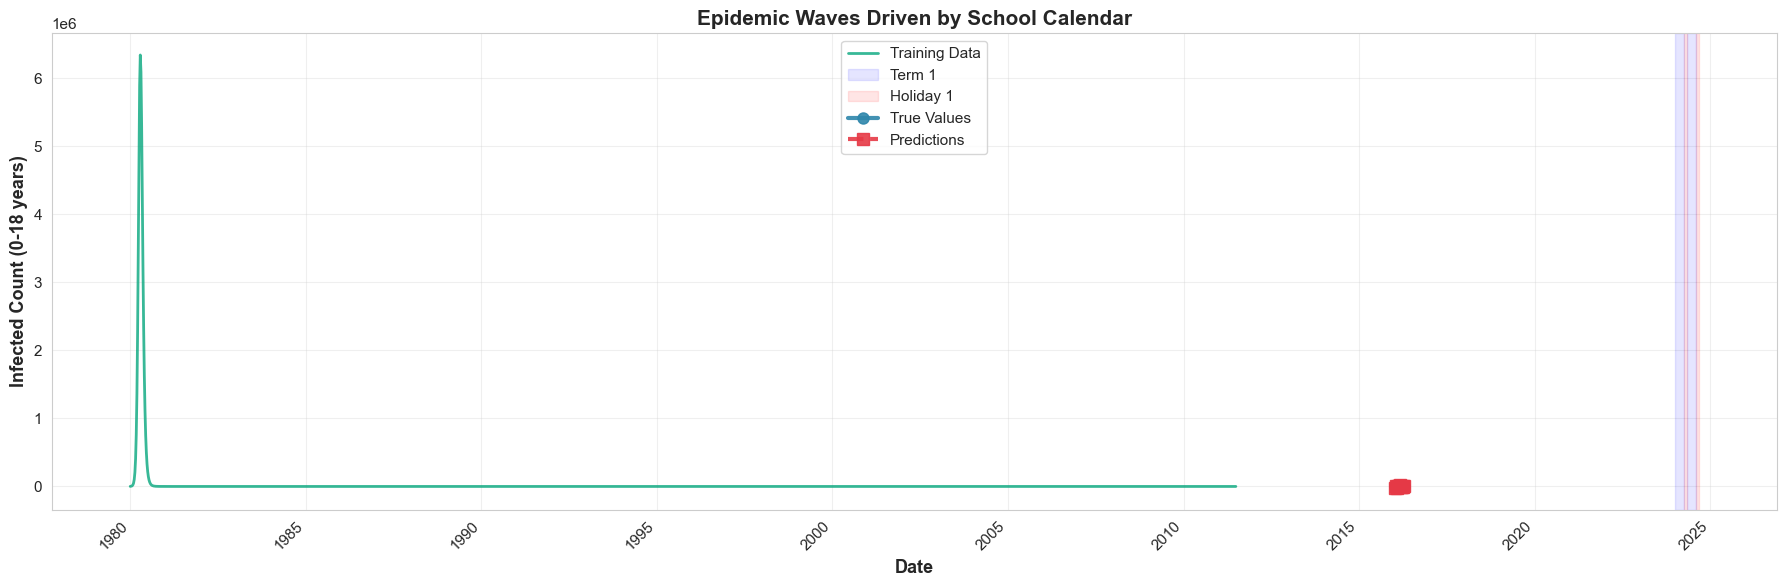

In [7]:
# Annotate the plot with school periods
fig, ax = plt.subplots(figsize=(18, 6))

# Plot training data
ax.plot(training_dates, training_data, color='#06A77D', linewidth=2, 
        label='Training Data', alpha=0.8)

# Add school period annotations (adjust dates based on your config)
school_terms = [
    ('2024-01-01', '2024-03-31', 'Term 1'),
    ('2024-05-01', '2024-07-31', 'Term 2'),
]

holidays = [
    ('2024-04-01', '2024-04-30', 'Holiday 1'),
    ('2024-08-01', '2024-08-31', 'Holiday 2'),
]

for start, end, label in school_terms:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.1, color='blue', label=label if label == 'Term 1' else None)
    
for start, end, label in holidays:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
               alpha=0.1, color='red', label=label if label == 'Holiday 1' else None)

# Add forecast
ax.plot(forecast_dates, forecast_true, 'o-', color='#2E86AB', 
        linewidth=3, markersize=8, label='True Values', alpha=0.9)
ax.plot(forecast_dates, forecast_pred, 's--', color='#E63946', 
        linewidth=3, markersize=9, label='Predictions', alpha=0.9)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Infected Count (0-18 years)', fontsize=13, fontweight='bold')
ax.set_title('Epidemic Waves Driven by School Calendar', fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


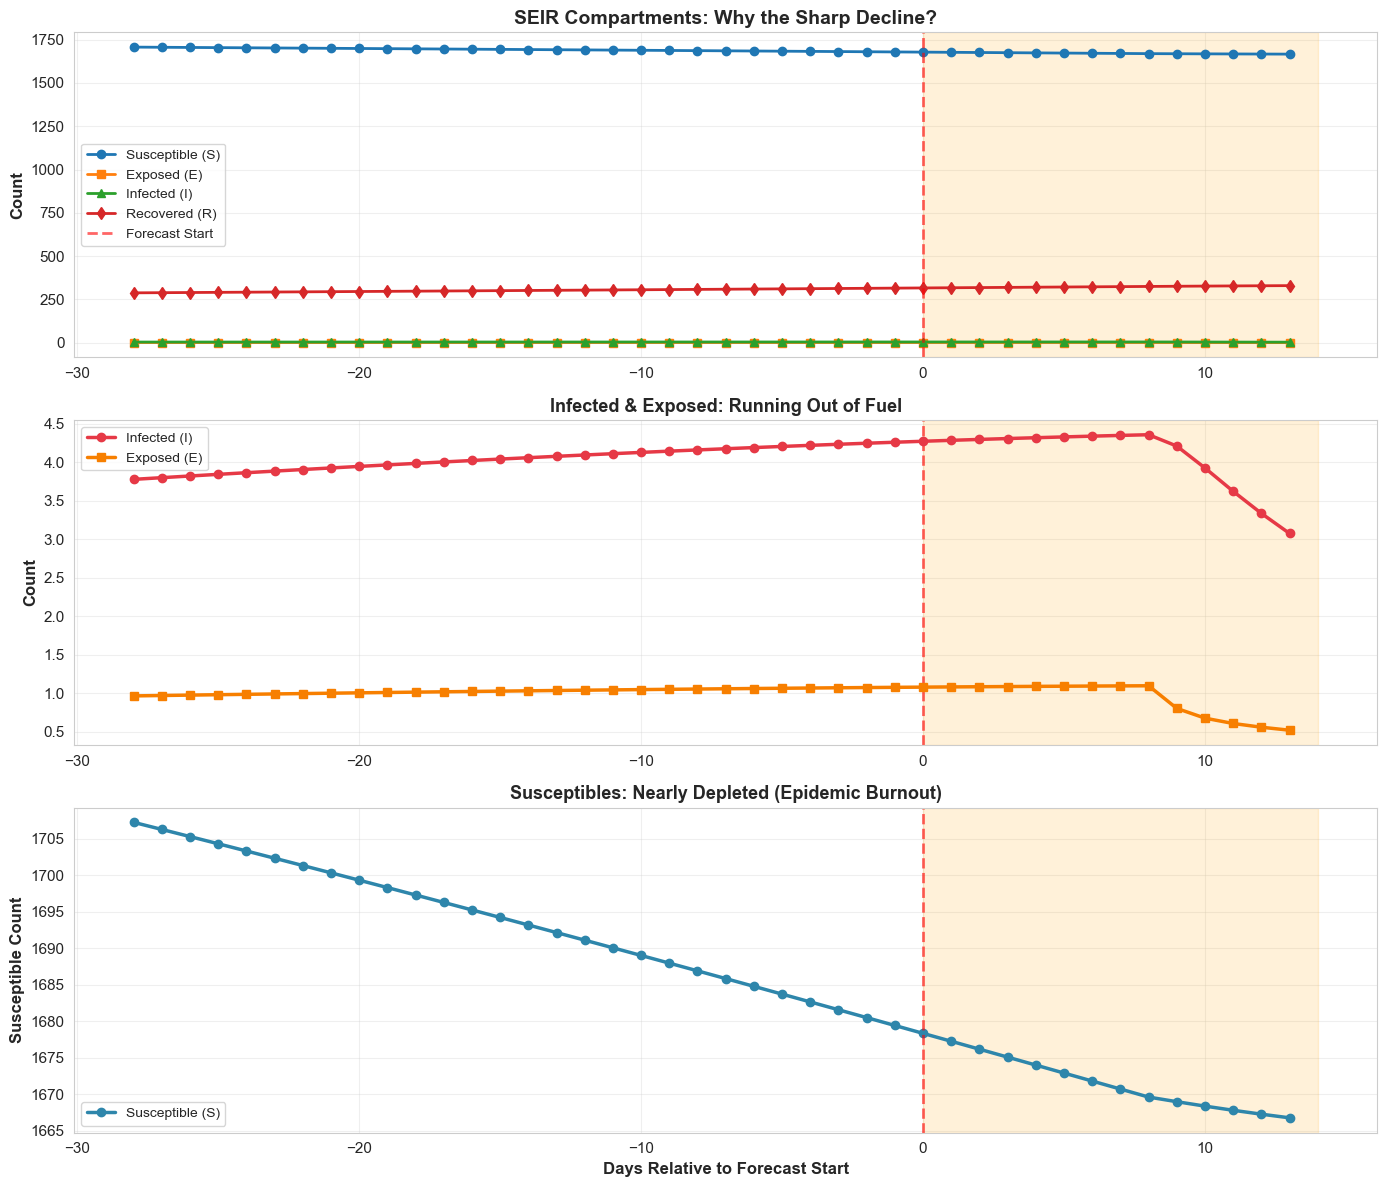

WHY THE SHARP DECLINE? EPIDEMIC BURNOUT ANALYSIS

At Forecast Start (day 0):
  Susceptible: 1678.33 (83.9% of population)
  Exposed:     1.08 (0.1%)
  Infected:    4.27 (0.2%)
  Recovered:   316.31 (15.8%)
  Total:       2000

At Forecast End (day 14):
  Susceptible: 1666.75 (83.3%)
  Infected:    3.08 (0.2%)
  Change in I: -1.20 (-28.0%)

ROOT CAUSES OF SHARP DECLINE:
1. SUSCEPTIBLE DEPLETION
   → Only 83.9% of population still susceptible
   → After two epidemic waves, most have recovered
   → Force of infection λ = τ × B × (I/N) × S requires susceptibles

2. EXPONENTIAL DECAY PHASE
   → Near epidemic extinction (die-out phase)
   → Infections decline exponentially when S is low
   → dI/dt becomes increasingly negative

3. LOW TRANSMISSION RATE (τ = 0.012)
   → Combined with low susceptibles = very slow spread
   → New infections can't sustain current level

4. SEIR CHAIN BREAKING
   → Exposed (E) pool also depleting: 1.08
   → Pipeline of new infections drying up


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Load data
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')
df = pd.read_csv(os.path.join(data_path, 'h1n1_2group_extended.csv'))
df['date'] = pd.to_datetime(df['date'])

# Calculate test border
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
test_border1 = len(df) - num_test - 28

# Get forecast window for sample 0
seq_len = 28
sample_idx = 0
forecast_start = test_border1 + sample_idx + seq_len
forecast_end = forecast_start + 14

# Extract SEIR data for forecast window + context
context_start = forecast_start - 28  # Show 28 days before forecast
context_end = forecast_end

context_df = df.iloc[context_start:context_end].copy()
context_df['days_relative'] = range(-28, 14)

# Create comprehensive visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: All SEIR compartments
ax1 = axes[0]
ax1.plot(context_df['days_relative'], context_df['S_0-18'], 'o-', label='Susceptible (S)', linewidth=2)
ax1.plot(context_df['days_relative'], context_df['E_0-18'], 's-', label='Exposed (E)', linewidth=2)
ax1.plot(context_df['days_relative'], context_df['I_0-18'], '^-', label='Infected (I)', linewidth=2)
ax1.plot(context_df['days_relative'], context_df['R_0-18'], 'd-', label='Recovered (R)', linewidth=2)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.6, label='Forecast Start')
ax1.axvspan(0, 14, alpha=0.15, color='orange')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('SEIR Compartments: Why the Sharp Decline?', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Zoom on Infected (I) and Exposed (E)
ax2 = axes[1]
ax2.plot(context_df['days_relative'], context_df['I_0-18'], 'o-', color='#E63946', 
         linewidth=2.5, markersize=6, label='Infected (I)', zorder=3)
ax2.plot(context_df['days_relative'], context_df['E_0-18'], 's-', color='#F77F00', 
         linewidth=2.5, markersize=6, label='Exposed (E)', zorder=3)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.6)
ax2.axvspan(0, 14, alpha=0.15, color='orange')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Infected & Exposed: Running Out of Fuel', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Susceptibles - The Key Driver
ax3 = axes[2]
ax3.plot(context_df['days_relative'], context_df['S_0-18'], 'o-', color='#2E86AB', 
         linewidth=2.5, markersize=6, label='Susceptible (S)')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.6)
ax3.axvspan(0, 14, alpha=0.15, color='orange')
ax3.set_xlabel('Days Relative to Forecast Start', fontsize=12, fontweight='bold')
ax3.set_ylabel('Susceptible Count', fontsize=12, fontweight='bold')
ax3.set_title('Susceptibles: Nearly Depleted (Epidemic Burnout)', fontsize=13, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'results', 'forecasts_child_2week', 'seir_dynamics_analysis.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Calculate statistics
print("="*70)
print("WHY THE SHARP DECLINE? EPIDEMIC BURNOUT ANALYSIS")
print("="*70)

# At forecast start
s_start = context_df[context_df['days_relative'] == 0]['S_0-18'].values[0]
e_start = context_df[context_df['days_relative'] == 0]['E_0-18'].values[0]
i_start = context_df[context_df['days_relative'] == 0]['I_0-18'].values[0]
r_start = context_df[context_df['days_relative'] == 0]['R_0-18'].values[0]
total_pop = s_start + e_start + i_start + r_start

print(f"\nAt Forecast Start (day 0):")
print(f"  Susceptible: {s_start:.2f} ({s_start/total_pop*100:.1f}% of population)")
print(f"  Exposed:     {e_start:.2f} ({e_start/total_pop*100:.1f}%)")
print(f"  Infected:    {i_start:.2f} ({i_start/total_pop*100:.1f}%)")
print(f"  Recovered:   {r_start:.2f} ({r_start/total_pop*100:.1f}%)")
print(f"  Total:       {total_pop:.0f}")

# At forecast end
s_end = context_df[context_df['days_relative'] == 13]['S_0-18'].values[0]
i_end = context_df[context_df['days_relative'] == 13]['I_0-18'].values[0]

print(f"\nAt Forecast End (day 14):")
print(f"  Susceptible: {s_end:.2f} ({s_end/total_pop*100:.1f}%)")
print(f"  Infected:    {i_end:.2f} ({i_end/total_pop*100:.1f}%)")
print(f"  Change in I: {i_end - i_start:.2f} ({(i_end - i_start)/i_start*100:.1f}%)")

print(f"\n" + "="*70)
print("ROOT CAUSES OF SHARP DECLINE:")
print("="*70)
print(f"1. SUSCEPTIBLE DEPLETION")
print(f"   → Only {s_start/total_pop*100:.1f}% of population still susceptible")
print(f"   → After two epidemic waves, most have recovered")
print(f"   → Force of infection λ = τ × B × (I/N) × S requires susceptibles")
print(f"\n2. EXPONENTIAL DECAY PHASE")
print(f"   → Near epidemic extinction (die-out phase)")
print(f"   → Infections decline exponentially when S is low")
print(f"   → dI/dt becomes increasingly negative")
print(f"\n3. LOW TRANSMISSION RATE (τ = 0.012)")
print(f"   → Combined with low susceptibles = very slow spread")
print(f"   → New infections can't sustain current level")
print(f"\n4. SEIR CHAIN BREAKING")
print(f"   → Exposed (E) pool also depleting: {e_start:.2f}")
print(f"   → Pipeline of new infections drying up")
print("="*70)


DATA SPLITS
Dataset: 366 days (2024-01-01 to 2024-12-31)

Train: rows 0-255 (256 rows)
  Dates: 2024-01-01 to 2024-09-12

Val:   rows 228-292 (65 rows, overlap with train)
  Dates: 2024-08-16 to 2024-10-19

Test:  rows 265-365 (101 rows)
  Dates: 2024-09-22 to 2024-12-31

Number of test forecasts: 56

Plotting 56 forecasts...

Plot saved to: /Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/results/forecasts_child_2week/complete_trajectory_with_forecasts.png


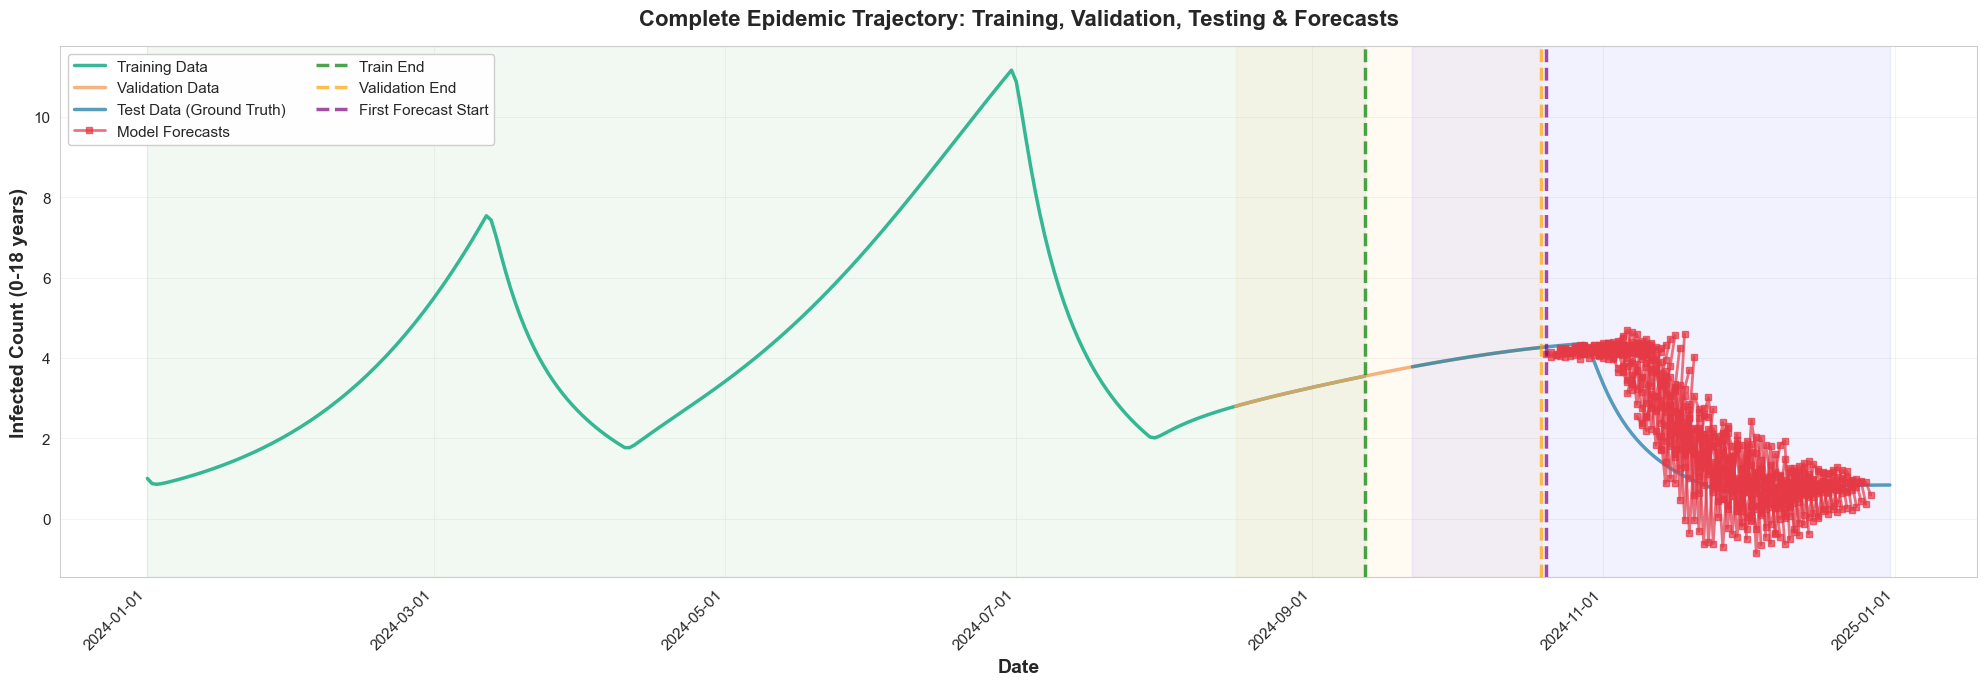


OVERALL FORECAST PERFORMANCE
Total forecast points: 784
Overall MAE: 0.85
Overall MAPE: 71.03%
True values range: [0.67, 4.36]
Predicted range: [-0.86, 4.70]


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# Set paths
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
results_path = os.path.join(base_path, 'results', 'forecasts_child_2week')
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')

# Load data
preds = np.load(os.path.join(results_path, 'predictions.npy'))
trues = np.load(os.path.join(results_path, 'true_values.npy'))
df = pd.read_csv(os.path.join(data_path, 'h1n1_2group_extended.csv'))
df['date'] = pd.to_datetime(df['date'])

# Parameters
pred_len = 14
seq_len = 28

# Calculate data splits (using Dataset_Custom logic)
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_vali = len(df) - num_train - num_test

# Border indices for each split
train_border1 = 0
train_border2 = num_train

val_border1 = num_train - seq_len
val_border2 = num_train + num_vali

test_border1 = len(df) - num_test - seq_len
test_border2 = len(df)

print("="*70)
print("DATA SPLITS")
print("="*70)
print(f"Dataset: {len(df)} days ({df.iloc[0]['date'].date()} to {df.iloc[-1]['date'].date()})")
print(f"\nTrain: rows {train_border1}-{train_border2-1} ({num_train} rows)")
print(f"  Dates: {df.iloc[train_border1]['date'].date()} to {df.iloc[train_border2-1]['date'].date()}")
print(f"\nVal:   rows {val_border1}-{val_border2-1} ({num_vali + seq_len} rows, overlap with train)")
print(f"  Dates: {df.iloc[val_border1]['date'].date()} to {df.iloc[val_border2-1]['date'].date()}")
print(f"\nTest:  rows {test_border1}-{test_border2-1} ({num_test + seq_len} rows)")
print(f"  Dates: {df.iloc[test_border1]['date'].date()} to {df.iloc[test_border2-1]['date'].date()}")
print(f"\nNumber of test forecasts: {len(preds)}")
print("="*70)

# Create figure
fig, ax = plt.subplots(figsize=(20, 7))

# Plot full time series with different colors for splits
train_df = df.iloc[train_border1:train_border2]
val_df = df.iloc[val_border1:val_border2]
test_df = df.iloc[test_border1:test_border2]

# Plot training data
ax.plot(train_df['date'], train_df['I_0-18'], color='#06A77D', linewidth=2.5, 
        label='Training Data', alpha=0.8, zorder=2)

# Plot validation data
ax.plot(val_df['date'], val_df['I_0-18'], color='#F4A261', linewidth=2.5, 
        label='Validation Data', alpha=0.8, zorder=2)

# Plot test data (ground truth)
ax.plot(test_df['date'], test_df['I_0-18'], color='#2E86AB', linewidth=2.5, 
        label='Test Data (Ground Truth)', alpha=0.8, zorder=3)

# Overlay all test forecasts
num_forecasts = len(preds)
print(f"\nPlotting {num_forecasts} forecasts...")

for idx in range(num_forecasts):
    # Calculate forecast window for this sample
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx <= len(df):
        forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date'].values
        pred_vals = preds[idx, :, 0]
        
        # Plot first forecast with label, rest without
        if idx == 0:
            ax.plot(forecast_dates, pred_vals, 's-', color='#E63946', linewidth=2, 
                   markersize=5, alpha=0.7, label='Model Forecasts', zorder=4)
        else:
            ax.plot(forecast_dates, pred_vals, 's-', color='#E63946', linewidth=2, 
                   markersize=5, alpha=0.7, zorder=4)

# Add vertical lines marking split boundaries
ax.axvline(x=df.iloc[train_border2-1]['date'], color='green', linestyle='--', 
           linewidth=2.5, alpha=0.7, label='Train End', zorder=5)

ax.axvline(x=df.iloc[val_border2-1]['date'], color='orange', linestyle='--', 
           linewidth=2.5, alpha=0.7, label='Validation End', zorder=5)

ax.axvline(x=df.iloc[test_border1 + seq_len]['date'], color='purple', linestyle='--', 
           linewidth=2.5, alpha=0.7, label='First Forecast Start', zorder=5)

# Shade regions
ax.axvspan(df.iloc[train_border1]['date'], df.iloc[train_border2-1]['date'], 
           alpha=0.05, color='green', zorder=1)
ax.axvspan(df.iloc[val_border1]['date'], df.iloc[val_border2-1]['date'], 
           alpha=0.05, color='orange', zorder=1)
ax.axvspan(df.iloc[test_border1]['date'], df.iloc[test_border2-1]['date'], 
           alpha=0.05, color='blue', zorder=1)

# Labels and title
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Infected Count (0-18 years)', fontsize=14, fontweight='bold')
ax.set_title('Complete Epidemic Trajectory: Training, Validation, Testing & Forecasts', 
             fontsize=16, fontweight='bold', pad=15)

# Format x-axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

# Legend
ax.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=2)

# Grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Tight layout
plt.tight_layout()

# Save
output_file = os.path.join(results_path, 'complete_trajectory_with_forecasts.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nPlot saved to: {output_file}")

plt.show()

# Calculate overall metrics
all_preds = []
all_trues = []

for idx in range(num_forecasts):
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx <= len(df):
        all_preds.append(preds[idx, :, 0])
        all_trues.append(trues[idx, :, 0])

all_preds = np.concatenate(all_preds)
all_trues = np.concatenate(all_trues)

overall_mae = np.mean(np.abs(all_preds - all_trues))
overall_mape = np.mean(np.abs((all_trues - all_preds) / (all_trues + 1e-8))) * 100

print("\n" + "="*70)
print("OVERALL FORECAST PERFORMANCE")
print("="*70)
print(f"Total forecast points: {len(all_preds)}")
print(f"Overall MAE: {overall_mae:.2f}")
print(f"Overall MAPE: {overall_mape:.2f}%")
print(f"True values range: [{all_trues.min():.2f}, {all_trues.max():.2f}]")
print(f"Predicted range: [{all_preds.min():.2f}, {all_preds.max():.2f}]")
print("="*70)


Plot saved to: /Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/results/forecasts_child_2week/individual_forecasts_with_context.png


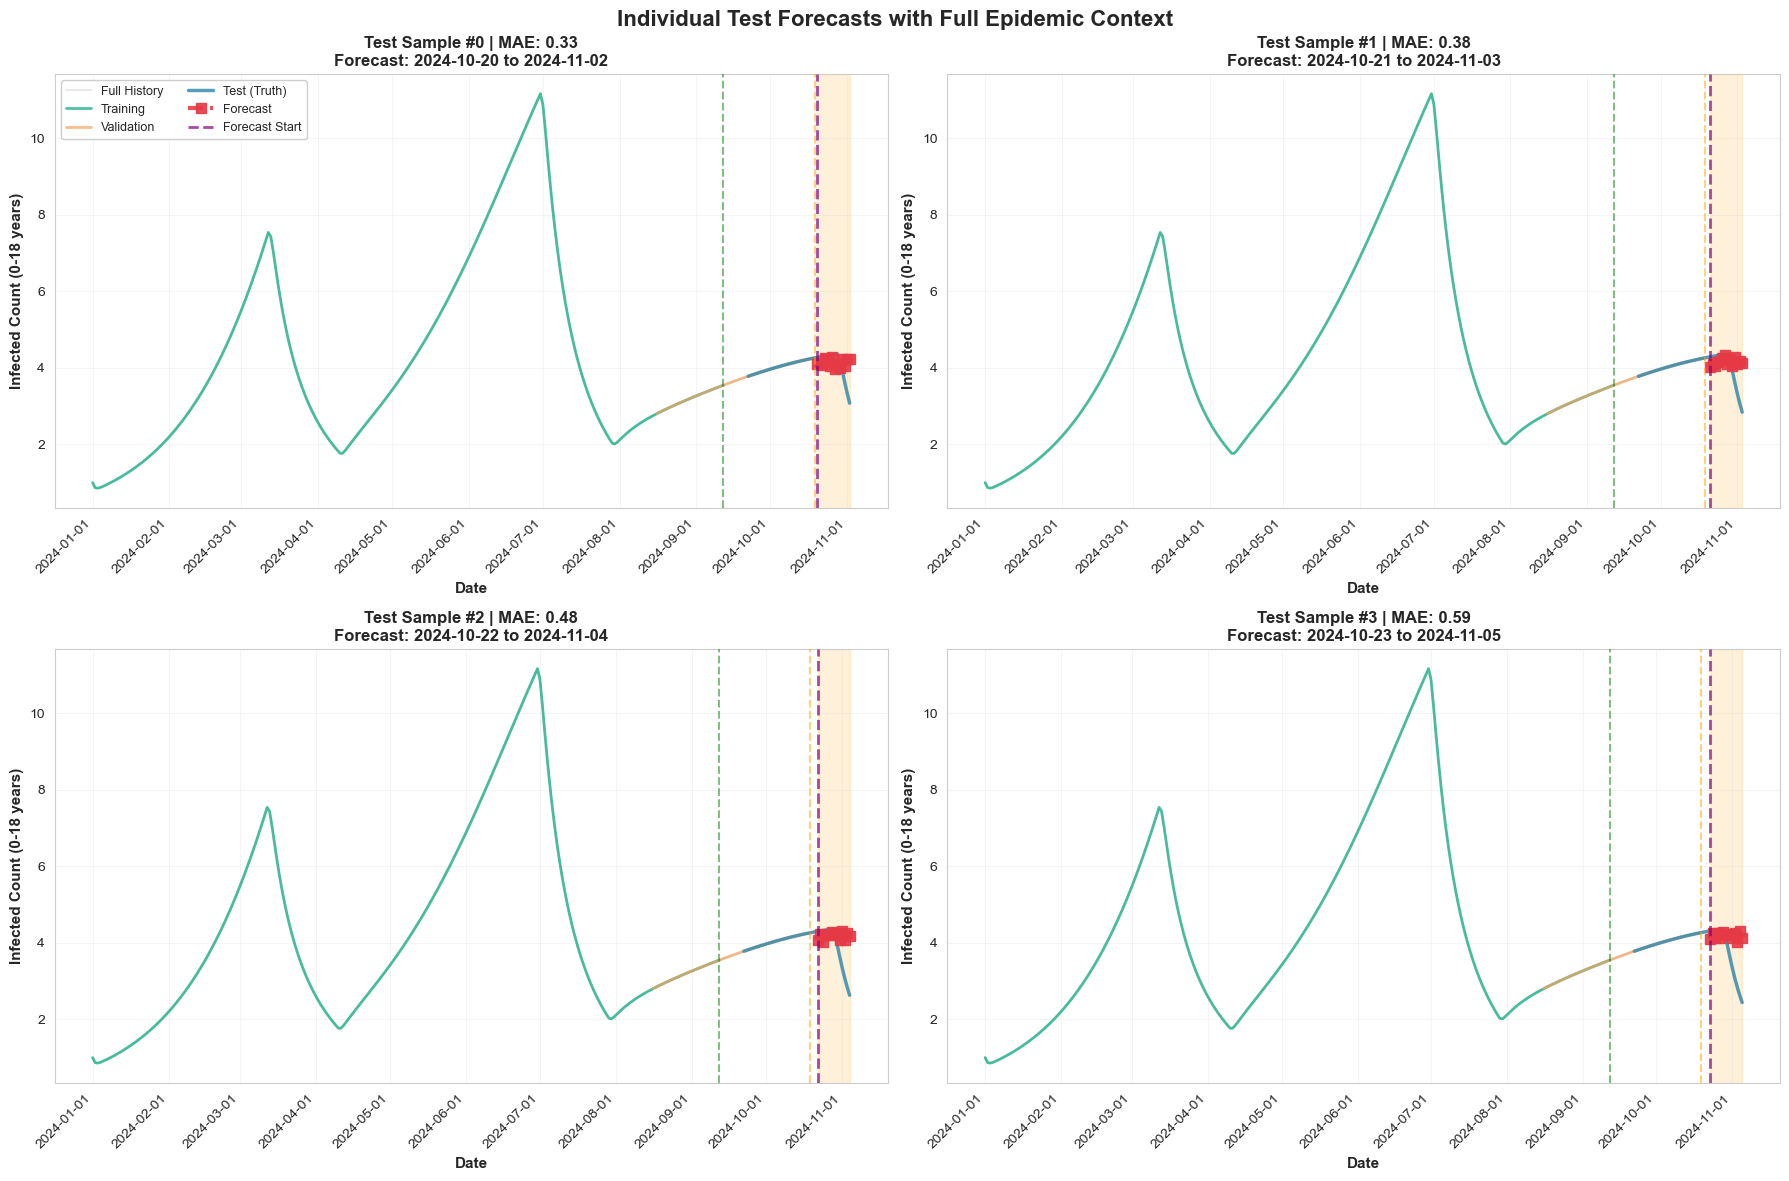


FORECAST SUMMARY

Sample 0:
  Period: 2024-10-20 to 2024-11-02
  MAE: 0.33
  True range: [3.08, 4.36]
  Pred range: [3.98, 4.29]

Sample 1:
  Period: 2024-10-21 to 2024-11-03
  MAE: 0.38
  True range: [2.84, 4.36]
  Pred range: [4.03, 4.32]

Sample 2:
  Period: 2024-10-22 to 2024-11-04
  MAE: 0.48
  True range: [2.63, 4.36]
  Pred range: [4.03, 4.31]

Sample 3:
  Period: 2024-10-23 to 2024-11-05
  MAE: 0.59
  True range: [2.44, 4.36]
  Pred range: [4.03, 4.30]


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Set paths
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
results_path = os.path.join(base_path, 'results', 'forecasts_child_2week')
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')

# Load data
preds = np.load(os.path.join(results_path, 'predictions.npy'))
trues = np.load(os.path.join(results_path, 'true_values.npy'))
df = pd.read_csv(os.path.join(data_path, 'h1n1_2group_extended.csv'))
df['date'] = pd.to_datetime(df['date'])

# Parameters
pred_len = 14
seq_len = 28

# Calculate data splits
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_vali = len(df) - num_train - num_test

train_border2 = num_train
val_border1 = num_train - seq_len
val_border2 = num_train + num_vali
test_border1 = len(df) - num_test - seq_len

# How many samples to show
num_samples = 4

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Individual Test Forecasts with Full Epidemic Context', 
             fontsize=16, fontweight='bold')

for idx in range(num_samples):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate forecast window for this sample
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx > len(df):
        break
    
    # Get full trajectory up to and including this forecast
    context_end = forecast_end_idx
    context_df = df.iloc[:context_end].copy()
    
    # Extract forecast data
    forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date'].values
    forecast_true = df.iloc[forecast_start_idx:forecast_end_idx]['I_0-18'].values
    forecast_pred = preds[idx, :, 0]
    
    mae = np.mean(np.abs(forecast_pred - forecast_true))
    
    # Convert dates for title
    start_date = pd.Timestamp(forecast_dates[0]).strftime('%Y-%m-%d')
    end_date = pd.Timestamp(forecast_dates[-1]).strftime('%Y-%m-%d')
    
    # Plot full trajectory
    ax.plot(context_df['date'], context_df['I_0-18'], color='lightgray', 
            linewidth=1.5, alpha=0.5, label='Full History', zorder=1)
    
    # Highlight training data
    train_df = df.iloc[:train_border2]
    ax.plot(train_df['date'], train_df['I_0-18'], color='#06A77D', 
            linewidth=2, alpha=0.7, label='Training', zorder=2)
    
    # Highlight validation data  
    val_df = df.iloc[val_border1:val_border2]
    ax.plot(val_df['date'], val_df['I_0-18'], color='#F4A261', 
            linewidth=2, alpha=0.7, label='Validation', zorder=2)
    
    # Highlight test data up to this forecast
    test_up_to_forecast = df.iloc[test_border1:forecast_end_idx]
    ax.plot(test_up_to_forecast['date'], test_up_to_forecast['I_0-18'], 
            color='#2E86AB', linewidth=2.5, alpha=0.8, label='Test (Truth)', zorder=3)
    
    # Plot forecast predictions
    ax.plot(forecast_dates, forecast_pred, 's--', color='#E63946', 
            linewidth=3, markersize=7, label='Forecast', alpha=0.9, zorder=4)
    
    # Add vertical lines
    ax.axvline(x=df.iloc[train_border2-1]['date'], color='green', 
               linestyle='--', linewidth=1.5, alpha=0.5, zorder=5)
    ax.axvline(x=df.iloc[val_border2-1]['date'], color='orange', 
               linestyle='--', linewidth=1.5, alpha=0.5, zorder=5)
    ax.axvline(x=forecast_dates[0], color='purple', 
               linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start', zorder=5)
    
    # Shade forecast window
    ax.axvspan(forecast_dates[0], forecast_dates[-1], 
               alpha=0.15, color='orange', zorder=0)
    
    # Labels and title (FIXED)
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Infected Count (0-18 years)', fontsize=11, fontweight='bold')
    ax.set_title(f'Test Sample #{idx} | MAE: {mae:.2f}\n' + 
                 f'Forecast: {start_date} to {end_date}', 
                 fontsize=12, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend (only for first plot to avoid clutter)
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9, framealpha=0.95, ncol=2)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()

# Save
output_file = os.path.join(results_path, 'individual_forecasts_with_context.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {output_file}")

plt.show()

# Print summary
print("\n" + "="*70)
print("FORECAST SUMMARY")
print("="*70)
for idx in range(num_samples):
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx <= len(df):
        forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date']
        forecast_true = df.iloc[forecast_start_idx:forecast_end_idx]['I_0-18'].values
        forecast_pred = preds[idx, :, 0]
        mae = np.mean(np.abs(forecast_pred - forecast_true))
        
        start_date = forecast_dates.iloc[0].strftime('%Y-%m-%d')
        end_date = forecast_dates.iloc[-1].strftime('%Y-%m-%d')
        
        print(f"\nSample {idx}:")
        print(f"  Period: {start_date} to {end_date}")
        print(f"  MAE: {mae:.2f}")
        print(f"  True range: [{forecast_true.min():.2f}, {forecast_true.max():.2f}]")
        print(f"  Pred range: [{forecast_pred.min():.2f}, {forecast_pred.max():.2f}]")
print("="*70)


Plot saved to: /Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/results/forecasts_child_2week/individual_forecasts_zoomed.png


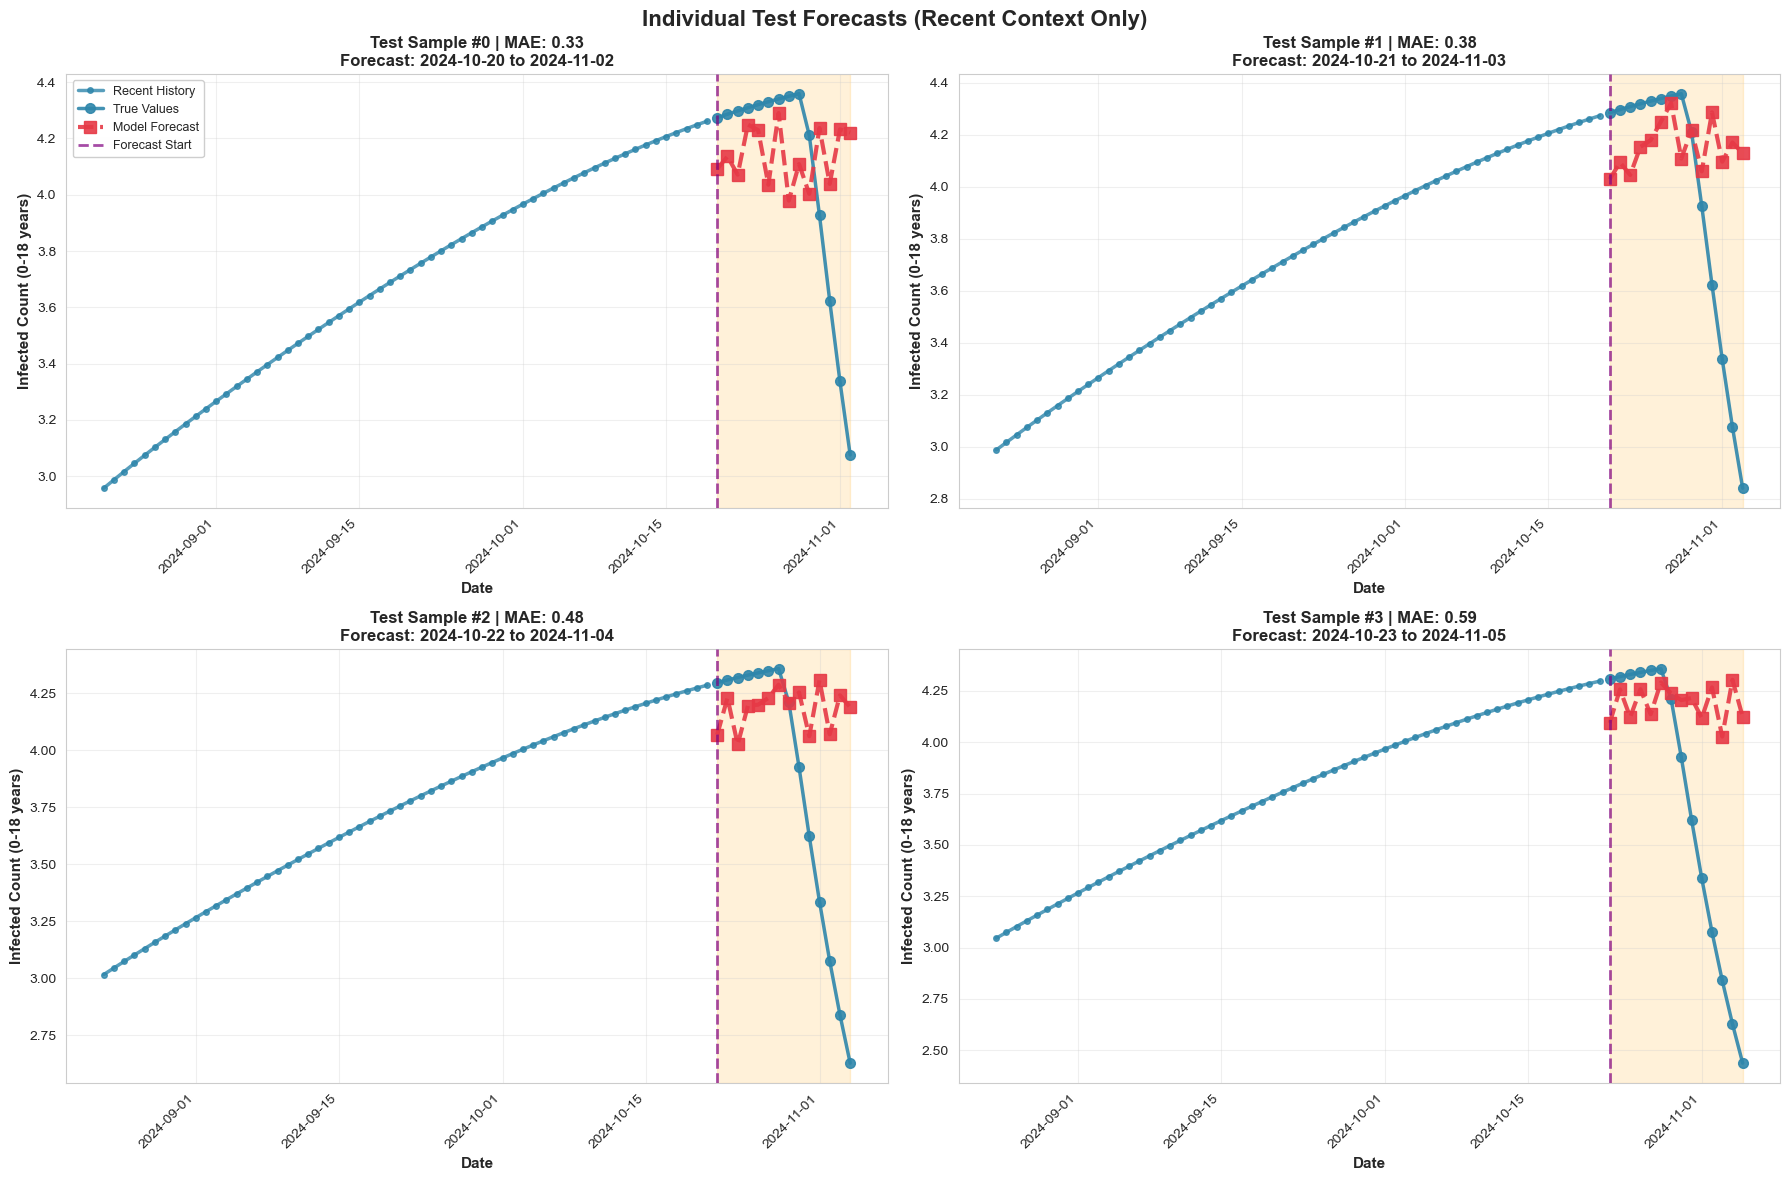


FORECAST SUMMARY (ZOOMED VIEW)

Sample 0:
  Period: 2024-10-20 to 2024-11-02
  MAE: 0.33
  True range: [3.08, 4.36]
  Pred range: [3.98, 4.29]

Sample 1:
  Period: 2024-10-21 to 2024-11-03
  MAE: 0.38
  True range: [2.84, 4.36]
  Pred range: [4.03, 4.32]

Sample 2:
  Period: 2024-10-22 to 2024-11-04
  MAE: 0.48
  True range: [2.63, 4.36]
  Pred range: [4.03, 4.31]

Sample 3:
  Period: 2024-10-23 to 2024-11-05
  MAE: 0.59
  True range: [2.44, 4.36]
  Pred range: [4.03, 4.30]


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Set paths
base_path = '/Users/apple/Downloads/IPLESP_SCAI_SU/LLM_FineTuning_Epidemics/TimeLLM-forecasting/'
results_path = os.path.join(base_path, 'results', 'forecasts_child_2week')
data_path = os.path.join(base_path, 'dataset', 'synthetic', 'h1n1')

# Load data
preds = np.load(os.path.join(results_path, 'predictions.npy'))
trues = np.load(os.path.join(results_path, 'true_values.npy'))
df = pd.read_csv(os.path.join(data_path, 'h1n1_2group_extended.csv'))
df['date'] = pd.to_datetime(df['date'])

# Parameters
pred_len = 14
seq_len = 28

# Calculate data splits
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_vali = len(df) - num_train - num_test

test_border1 = len(df) - num_test - seq_len

# How many samples to show
num_samples = 4

# Show only recent N days before forecast
context_days = 60  # Show 60 days of context

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Individual Test Forecasts (Recent Context Only)', 
             fontsize=16, fontweight='bold')

for idx in range(num_samples):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate forecast window
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx > len(df):
        break
    
    # Get recent context only
    context_start = max(0, forecast_start_idx - context_days)
    context_end = forecast_start_idx
    context_df = df.iloc[context_start:context_end].copy()
    
    # Extract forecast data
    forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date'].values
    forecast_true = df.iloc[forecast_start_idx:forecast_end_idx]['I_0-18'].values
    forecast_pred = preds[idx, :, 0]
    
    mae = np.mean(np.abs(forecast_pred - forecast_true))
    
    # Convert dates for title
    start_date = pd.Timestamp(forecast_dates[0]).strftime('%Y-%m-%d')
    end_date = pd.Timestamp(forecast_dates[-1]).strftime('%Y-%m-%d')
    
    # Plot recent context
    ax.plot(context_df['date'], context_df['I_0-18'], 'o-', color='#2E86AB', 
            linewidth=2.5, markersize=4, alpha=0.8, label='Recent History', zorder=3)
    
    # Plot ground truth in forecast window
    ax.plot(forecast_dates, forecast_true, 'o-', color='#2E86AB', 
            linewidth=2.5, markersize=7, alpha=0.9, label='True Values', zorder=3)
    
    # Plot forecast predictions
    ax.plot(forecast_dates, forecast_pred, 's--', color='#E63946', 
            linewidth=3, markersize=8, label='Model Forecast', alpha=0.9, zorder=4)
    
    # Add vertical line at forecast start
    ax.axvline(x=forecast_dates[0], color='purple', 
               linestyle='--', linewidth=2, alpha=0.7, label='Forecast Start', zorder=5)
    
    # Shade forecast window
    ax.axvspan(forecast_dates[0], forecast_dates[-1], 
               alpha=0.15, color='orange', zorder=0)
    
    # Labels and title (FIXED)
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_ylabel('Infected Count (0-18 years)', fontsize=11, fontweight='bold')
    ax.set_title(f'Test Sample #{idx} | MAE: {mae:.2f}\n' + 
                 f'Forecast: {start_date} to {end_date}', 
                 fontsize=12, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    if idx == 0:
        ax.legend(loc='best', fontsize=9, framealpha=0.95)
    
    # Grid
    ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save
output_file = os.path.join(results_path, 'individual_forecasts_zoomed.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {output_file}")

plt.show()

# Print summary
print("\n" + "="*70)
print("FORECAST SUMMARY (ZOOMED VIEW)")
print("="*70)
for idx in range(num_samples):
    forecast_start_idx = test_border1 + idx + seq_len
    forecast_end_idx = forecast_start_idx + pred_len
    
    if forecast_end_idx <= len(df):
        forecast_dates = df.iloc[forecast_start_idx:forecast_end_idx]['date']
        forecast_true = df.iloc[forecast_start_idx:forecast_end_idx]['I_0-18'].values
        forecast_pred = preds[idx, :, 0]
        mae = np.mean(np.abs(forecast_pred - forecast_true))
        
        start_date = forecast_dates.iloc[0].strftime('%Y-%m-%d')
        end_date = forecast_dates.iloc[-1].strftime('%Y-%m-%d')
        
        print(f"\nSample {idx}:")
        print(f"  Period: {start_date} to {end_date}")
        print(f"  MAE: {mae:.2f}")
        print(f"  True range: [{forecast_true.min():.2f}, {forecast_true.max():.2f}]")
        print(f"  Pred range: [{forecast_pred.min():.2f}, {forecast_pred.max():.2f}]")
print("="*70)
